In [166]:
import wikipedia
import re
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

wikipedia.set_lang("en")

all_mountains = [
    "Everest", "K2", "Kangchenjunga", "Lhotse", "Makalu",
    "Cho Oyu", "Dhaulagiri", "Manaslu", "Nanga Parbat", "Annapurna",
    "Shishapangma", "Mount Fuji", "Denali", "Mount Kilimanjaro", "Matterhorn"
]

# Text Cleaning and Extraction Functions

In [24]:
def get_sentences(topic, n=600):
    sentences = []

    url = f"https://sentence.yourdictionary.com/{topic}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed for '{topic}'")
        return

    soup = BeautifulSoup(response.text, "html.parser")
    raw_sents = [s.text.strip() for s in soup.select(".sentence-item__text")]
    if not raw_sents:
        return

    cleaned = []
    for s in raw_sents:
        if topic.lower() in s.lower():
            cleaned.append(s.replace("\n", " ").strip())

    sentences.extend(cleaned)

    if len(sentences) > n:
        sentences = random.sample(sentences, n)

    return sentences

In [10]:
def clean_text(text):
    """
    Clean Wikipedia text by removing section headers and non-Latin characters.
    """
    text = re.sub(r"==.*?==", " ", text)  # remove headers
    text = re.sub(r"[^A-Za-z0-9.,;:'\"!?()\-\s]", " ", text)  # remove non-Latin chars
    text = re.sub(r"\s+", " ", text).strip()
    return text


def get_sentence_variants(mountain):
    """
    Returns: 'Mount Everest' -> ['Mount Everest', 'Everest']
    """
    if mountain.startswith("Mount "):
        short_name = mountain.replace("Mount ", "")
        return [mountain, short_name]
    return [mountain]


def get_sentences_for_mountain(mountain):
    try:
        page = wikipedia.page(mountain, auto_suggest=False)
        text = clean_text(page.content)
        sentences = re.split(r'(?<=[.!?])\s+', text)
        variants = get_sentence_variants(mountain)

        filtered, seen = [], set()
        for s in sentences:
            if any(v in s for v in variants):
                s_clean = s.strip()
                if s_clean not in seen:
                    seen.add(s_clean)
                    filtered.append(s_clean)

        return filtered

    except Exception as e:
        print(f"Error fetching {mountain}: {e}")
        return []

In [20]:
def count_sentences_per_mountain(df):
    counts = (
        df.groupby("word")["sentence"]
        .count()
        .reset_index(name="count")
        .sort_values(by="count", ascending=False)
        .reset_index(drop=True)
    )
    return counts


# Collecting wikipedia data

In [11]:
data = []
for m in tqdm(all_mountains, desc="Collecting wikipedia data"):
    sents = get_sentences_for_mountain(m)
    for s in sents:
        data.append({"word": m, "sentence": s})

df = pd.DataFrame(data)
df.drop_duplicates(subset="sentence", inplace=True)
print(f"Collected {len(df)} unique sentences from {len(all_mountains)} mountains.")

df.to_csv("mountain_sentences.csv", index=False)
print("Saved to mountain_sentences.csv")

Collected 886 unique sentences from 15 mountains.
Saved to mountain_sentences.csv


In [17]:
df['sentence'][0]

"Mount Everest (known locally as Sagarm th in Nepal and Qomolangma in Tibet) is Earth's highest mountain above sea level."

In [21]:
mountain_counts = count_sentences_per_mountain(df)
mountain_counts

,word,count
0,Everest,166
1,Matterhorn,121
2,K2,82
3,Kangchenjunga,79
4,Mount Fuji,73
5,Mount Kilimanjaro,73
6,Manaslu,61
7,Denali,59
8,Nanga Parbat,44
9,Lhotse,39


In [42]:
mountain_counts["count"].sum()

886

The dataset is clearly imbalanced, with some mountains like Everest and Matterhorn having many more sentences than others. This imbalance is caused by differences in the amount of available Wikipedia content. To reduce its impact on the final model, additional synthetic data was generated to balance all classes.


# Generation of additional data

Sentences containing the word *“mountain”* will be collected from the website [sentence.yourdictionary.com](https://sentence.yourdictionary.com/). The word will then be replaced with the names of mountains that lack enough samples. This approach will ensure an average of 80 sentences per mountain, except for those that already have more, given the limited number of available sentences on the website.


In [36]:
def fill_missing_mountains_unique(df, all_mountains, sent, target_count=80):
    """
    Ensures each mountain has at least `target_count` sentences.
    Each base sentence is used only once.
    """
    new_rows = []
    used_sentences = set()

    for m in tqdm(all_mountains, desc="Filling missing mountains"):
        current_count = df[df["word"] == m].shape[0]
        needed = target_count - current_count

        if needed > 0:
            available_sent = [s for s in sent if s not in used_sentences and "mountain" in s.lower()]
            if not available_sent:
                break

            selected = random.sample(available_sent, min(needed, len(available_sent)))
            for s in selected:
                used_sentences.add(s)
                new_sentence = re.sub(r"\bmountain(s)?\b", m, s, flags=re.IGNORECASE)
                new_rows.append({"word": m, "sentence": new_sentence})

    df_new = pd.DataFrame(new_rows)
    df_final = pd.concat([df, df_new], ignore_index=True)
    df_final.drop_duplicates(subset="sentence", inplace=True)
    df_final.reset_index(drop=True, inplace=True)
    return df_final

In [29]:
sent = get_sentences("mountain")
print(f"Total number of sentences: {len(sent)}")
print(f"Example of sentence\n{sent[:3]}")


Total number of sentences: 500
Example of sentence
['The cool mountain air made her shiver.', "I didn't know this mountain was so tall.", 'He was studying the mountain ranges intently.']


In [54]:
df_filled = fill_missing_mountains_unique(df, all_mountains, sent, target_count=80)
df_filled.to_csv("mountain_sentences_filled.csv", index=False)
df_filled.head()


Filling missing mountains: 100%|██████████| 15/15 [00:00<00:00, 1154.88it/s]


,word,sentence
0,Everest,Mount Everest (known locally as Sagarm th in N...
1,Everest,"Mount Everest attracts many climbers, includin..."
2,Everest,While not posing substantial technical climbin...
3,Everest,"As of May 2024, 340 people have died on Everest."
4,Everest,Climbers typically ascend only part of Mount E...


In [43]:
mountain_counts = count_sentences_per_mountain(df_filled)
mountain_counts

,word,count
0,Everest,166
1,Matterhorn,121
2,K2,82
3,Annapurna,80
4,Cho Oyu,80
5,Denali,80
6,Dhaulagiri,80
7,Kangchenjunga,80
8,Lhotse,80
9,Makalu,80


In [44]:
mountain_counts["count"].sum()

1329

By adding new sentences, we made the dataset more balanced.


# Adding non-mountain data 


To ensure the dataset does not contain only sentences mentioning mountain names, additional sentences containing the word *“hiking”* were collected. These examples introduce more linguistic variety and help the model learn to distinguish between sentences that mention mountains and those that do not. The number of *hiking* sentences was set to 15% of the total dataset size to maintain balance while improving generalization.


In [57]:
hiking_sents = get_sentences("hiking", int((df_filled["sentence"].count() * 0.15)))
df_hiking = pd.DataFrame({
    "word": ["hiking"] * len(hiking_sents),
    "sentence": hiking_sents
})

df_combined = pd.concat([df_filled, df_hiking], ignore_index=True)
df_combined.drop_duplicates(subset="sentence", inplace=True)
df_combined.to_csv("mountain_sentences_final.csv", index=False)

print(f"Final dataset saved — total {len(df_combined)} unique sentences.")
df_combined.sample(10)

Final dataset saved — total 1528 unique sentences.


,word,sentence
140,Everest,"In 2014, a team financed and led by mountainee..."
1451,hiking,This type of camping and hunting is rugged and...
841,Matterhorn,"Today, all ridges and faces of the Matterhorn ..."
696,Mount Kilimanjaro,The mountain was incorporated into Kilimanjaro...
104,Everest,"At the higher regions of Mount Everest, climbe..."
352,Lhotse,1999 Attempt to climb Lhotse Middle and traver...
367,Makalu,"One of the eight-thousanders, Makalu is an iso..."
102,Everest,"The summit of Everest has been described as ""t..."
497,Nanga Parbat,"While the team were all strong climbers, none ..."
993,Cho Oyu,It seemed every other rider had passed him on ...


# EDA

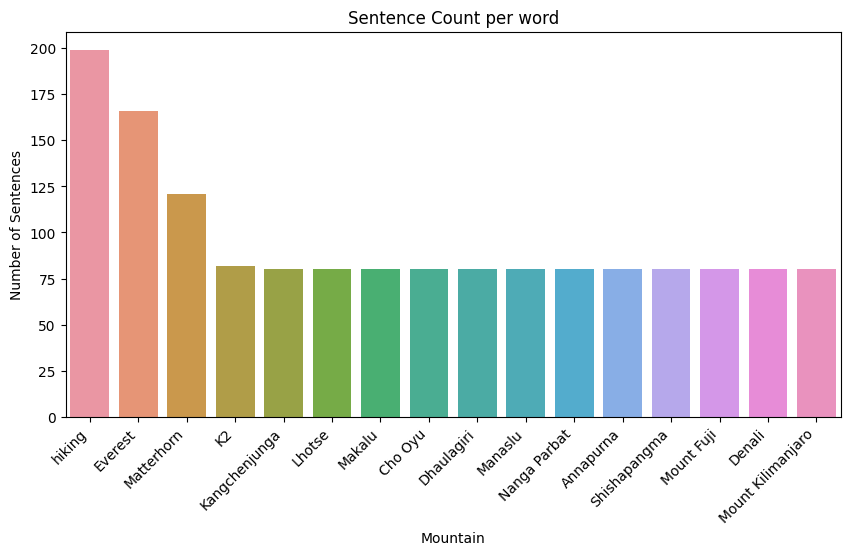

In [55]:
plt.figure(figsize=(10, 5))
mountain_distribution = df_combined["word"].value_counts()
sns.barplot(x=mountain_distribution.index, y=mountain_distribution.values)
plt.xticks(rotation=45, ha="right")
plt.title("Sentence Count per word")
plt.xlabel("Mountain")
plt.ylabel("Number of Sentences")
plt.show()


In [53]:
print("Dataset size:", len(df_combined))
print("Unique mountains:", df_combined['word'].nunique())

for m in random.sample(all_mountains, 3):
    sample = df_combined[df_combined["word"] == m].sample(3)["sentence"].tolist()
    print(f"\n--- {m} ---")
    for s in sample:
        print(s)


Dataset size: 1528
Unique mountains: 16

--- Manaslu ---
During this exploration, while making a reconnaissance of the higher reaches of the Dudh Khola, they clearly saw Manaslu from Bumtang.
Do you think we chased the Manaslu lion away?
The route Alex chose meandered through the gorge and then up a steep deer trail to the top of the Manaslu.

--- Mount Fuji ---
According to UNESCO, Mount Fuji has "inspired artists and poets and been the object of pilgrimage for centuries".
The part of the Elburz immediately north of Teheran is known as the Kuh i Shimran (Mount Fuji of Shimran, from the name of the Shimran district on its southern slopes) and culminates in the Sar i Tochal (12,600 ft.).
It was named Fuji before the kanji was applied to it.

--- Denali ---
Leyon followed, and Mansr took her into a small dwelling on the Denali.
On January 20, 2025, shortly after his second inauguration, Trump signed an executive order requiring the secretary of the interior to revert the Obama-era name c